# Example 02 – Dynamics

In this tutorial, we will show how to use `pystrel` to solve quantum dynamics. 
Our goal is to solve the time-dependent Schrödinger equation

$$
    i\partial_t |\psi\rangle = H |\psi \rangle,
$$

where the system Hamiltonian $H$ can depend on time $t$ as well, i.e., $H = H(t)$.

The dynamics utilities are implemented in `pystrel.dynamics`. 
These utilities can be applied to arbitrary Hamiltonians, not restricted to Hamiltonians generated within the package itself.

The method `pystrel.dynamics.propagate(state, hamiltonian, t, dt)` is used to propagate the state `state` by `dt` from time `t`, assuming that the system is described by the `hamiltonian`. The `hamiltonian` can be either a constant (e.g., `np.ndarray`) or time-dependent (e.g., a lambda of type `(time) -> np.ndarray`).

In the examples below, we will investigate cases for both simple single-particle Hamiltonians, which are well-known in the literature and have analytical solutions/approximations.

> **Hint:**  
> There are more optional parameters available, such as the numerical `method` to use. 
> Currently, there are two implementations:
>
> - `"cheb"`: based on Chebyshev polynomial expansion,
> - `"rk4"`: based on the 4th-order Runge-Kutta method.
>
> For more details, refer to the [`pystrel.dynamics`](https://andywiecko.github.io/pystrel/pystrel/dynamics.html) documentation.

In [1]:
import pystrel as ps
import numpy as np
import matplotlib.pyplot as plt

## Time-independent Hamiltonian (Rabi oscillations)

This example contains a full solution for the Hamiltonian that describes *Rabi oscillations*

$$
H = a\, \sigma_z + b\, \sigma_x.
$$

It can be shown that for the evolution with the initial state $|\psi(0)\rangle = |0\rangle$, the probability $\mathcal P_{|1\rangle}$ of observing state $|1\rangle$ is given by

$$
\mathcal P_{|1\rangle} = \frac{b^2}{a^2 + b^2} \sin^2\left(\sqrt{a^2 + b^2} t\right).
$$

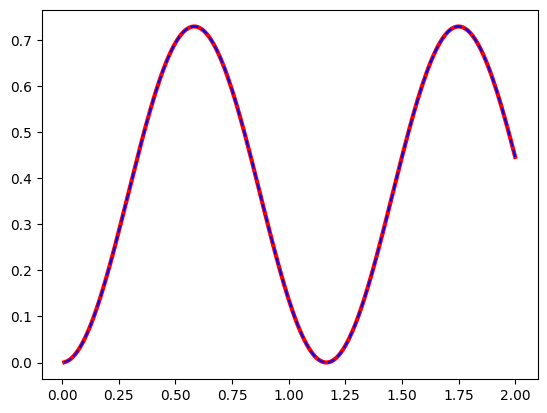

In [2]:
a = 1.4
b = 2.3
psi = np.array([1.0, 0], dtype=np.complex128)
sz = np.array([[1.0, 0], [0, -1]])
sx = np.array([[0.0, 1], [1, 0]])
h = a * sz + b * sx

t = 0.0
dt = 0.01
T = []
p = []

for _ in range(200):
    psi = ps.propagate(psi, h, t, dt)
    t += dt

    T.append(t)
    p.append(np.abs(psi[1]) ** 2)

expected = (
    b**2 / (a**2 + b**2) * np.sin(np.sqrt(a**2 + b**2) * np.array(T)) ** 2
)
result = np.array(p)

plt.plot(T, result, lw=3, color='red')
plt.plot(T, expected, '--', color='blue')
plt.show()

## Time-dependent Hamiltonian (Landau-Zener transition)

In this example, we will show how to solve *time-dependent* Hamiltonians. 
The example presents a well-known phenomenon of Landau-Zener transition, which can be studied within the following Hamiltonian:

$$
H(t) = \frac{1}{2} (a\, \sigma_z t + b\, \sigma_x).
$$

Assuming that the initial state is the ground state of $H(-\infty)$, it can be shown that during the evolution from $t=-\infty$ to $t=+\infty$, the probability that the state will remain in the ground state is equal to

$$
\mathcal P_{|0\rangle} = 1 - \exp\left(-\frac{\pi b^2}{2a}\right).
$$

> **Note**  
> [@andywiecko](https://github.com/andywiecko/): For a full derivation of $\mathcal P_{|0\rangle}$, see appendix B in [my old MSc thesis (2018, 🇬🇧/🇺🇸)](https://andywiecko.github.io/assets/msc_thesis.pdf).

In [3]:
def run(a, b) -> float:
    sz = np.array([[1.0, 0], [0, -1]])
    sx = np.array([[0.0, 1], [1, 0]])
    h = lambda t: 0.5 * (a * sz * t + b * sx) 

    T = 10.0
    t = -T
    dt = 0.01

    _, v = ps.spectrum.get_full_spectrum(h(-T))
    psi = v[0].astype(np.complex128)

    while t < T:
        psi = ps.propagate(psi, h, t, dt)
        t += dt

    _, v = ps.spectrum.get_full_spectrum(h(+T))
    psi0 = v[0].astype(np.complex128)
    p = ps.project(psi0, psi)
    return p

p_expected = lambda a, b: 1 - np.exp(-np.pi / 2.0 * b**2 / a)

a = 1.0
x = []
y_result = []
y_expected = []
for b in np.linspace(0, 3, 30):
    print(b, y := run(a, b), ye := p_expected(a, b))
    x.append(b)
    y_result.append(y)
    y_expected.append(ye)

0.0 0.0 0.0
0.10344827586206896 0.01665664851517686 0.016669449972033346
0.20689655172413793 0.06497606332714337 0.06502902709961589
0.3103448275862069 0.1402768758664244 0.14040122492053764
0.41379310344827586 0.23559633741991015 0.2358255520039486
0.5172413793103449 0.34275292435297816 0.3431165805555699
0.6206896551724138 0.45349774477927646 0.4540119319231686
0.7241379310344828 0.560532101266722 0.561189442625641
0.8275862068965517 0.6582243467165806 0.6589876970192236
0.9310344827586207 0.7429475646945225 0.743751051725891
1.0344827586206897 0.813052301459239 0.8138113515050949
1.1379310344827587 0.8685604247834111 0.8691892693677227
1.2413793103448276 0.9107025861979706 0.9111346189896464
1.3448275862068966 0.9414212143194045 0.9416258046516869
1.4482758620689655 0.9629327489532287 0.9629226854810039
1.5517241379310345 0.9774016577935393 0.9772283395781189
1.6551724137931034 0.9867389726653834 0.9864767775910274
1.7586206896551724 0.9925093471577415 0.9922345836368381
1.862068965

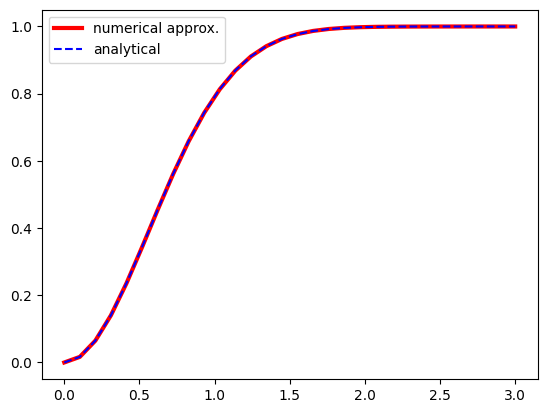

In [4]:
plt.plot(x, y_result, lw=3, color='red', label='numerical approx.')
plt.plot(x, y_expected, '--', color='blue', label='analytical')
plt.legend()
plt.show()